In [8]:
import tensorflow as tf
import numpy as np
from fcrbm_utilities import FCRBM

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Flatten the images from (28, 28) to a vector of 784 and normalize
# The RBM expects a flattened vector, not a 2D image
x_train = x_train.reshape(-1, 784).astype('float32') / 255.0

# One-hot encode the labels
# There are 10 classes (0-9) so the style dimension will be 10
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=10)


v_data = tf.constant(x_train, dtype=tf.float32)
y_data = tf.constant(y_train_one_hot, dtype=tf.float32)
u_data = tf.zeros_like(v_data, dtype=tf.float32)

# Print the shapes to verify
print("MNIST data successfully loaded and preprocessed! ✅")
print(f"Visible data (flattened images) shape: {v_data.shape}")
print(f"History data (zero-filled) shape: {u_data.shape}")
print(f"Style data (one-hot vectors) shape: {y_data.shape}")

MNIST data successfully loaded and preprocessed! ✅
Visible data (flattened images) shape: (60000, 784)
History data (zero-filled) shape: (60000, 784)
Style data (one-hot vectors) shape: (60000, 10)


In [4]:
# The visible dimension is the size of the flattened image (28 * 28)
visible_dim = 784

# The hidden dimension can be tuned, but 100 is a good starting point
hidden_dim = 100

# The style dimension is the number of classes (0-9)
style_dim = 10

# The history dimension matches the visible dimension
history_dim = visible_dim

# Set your training parameters
learning_rate = 0.00001 # A small learning rate is still crucial
epochs = 5
batch_size = 128

In [5]:
# Instantiate the FCRBM with the new parameters
fcrbm = FCRBM(
    visible_dim=visible_dim,
    hidden_dim=hidden_dim,
    style_dim=style_dim,
    history_dim=visible_dim,
    k=1
)

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Create a repeatable dataset from the MNIST tensors
num_total_samples = v_data.shape[0]
dataset = tf.data.Dataset.from_tensor_slices((v_data, u_data, y_data)).shuffle(buffer_size=num_total_samples).batch(batch_size).repeat()

# Set the number of steps per epoch
steps_per_epoch = num_total_samples // batch_size

# Training loop
for epoch in range(epochs):
    epoch_loss = 0
    # Iterate for a fixed number of steps
    for step in range(steps_per_epoch):
        v_batch, u_batch, y_batch = next(iter(dataset))
        loss = fcrbm.train_step(v_batch, u_batch, y_batch, optimizer)
        epoch_loss += loss.numpy()
        
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / steps_per_epoch:.4f}")

Epoch 1/5, Loss: 0.1519
Epoch 2/5, Loss: 0.1913
Epoch 3/5, Loss: 0.1916
Epoch 4/5, Loss: 0.1832
Epoch 5/5, Loss: 0.1746


AttributeError: 'FCRBM' object has no attribute 'gibbs_sampling_inference'

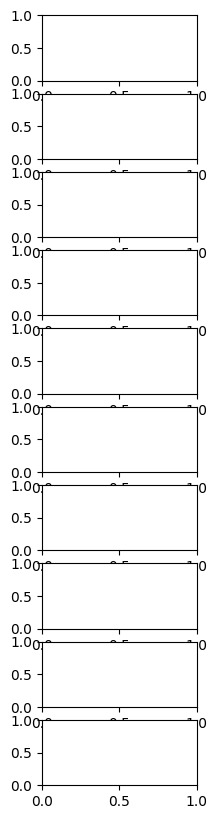

In [9]:
import matplotlib.pyplot as plt

# Assuming your FCRBM model has already been trained

# Define the parameters for the generation
num_digits = 10
visible_dim = 784
style_dim = 10
num_samples_per_digit = 1

# Create a figure to display the generated digits
fig, axes = plt.subplots(num_digits, num_samples_per_digit, figsize=(2, 10))

# Generate one image for each digit (0-9)
for digit in range(num_digits):
    # 1. Prepare the input tensors for a single sample
    # Initialize the visible layer with random noise
    initial_image = tf.random.normal(shape=(1, visible_dim), mean=0, stddev=1, dtype=tf.float32)
    
    # Create the one-hot encoded style vector for the current digit
    y_input = tf.keras.utils.to_categorical([digit], num_classes=style_dim)
    y_input = tf.constant(y_input, dtype=tf.float32)
    
    # The history layer is all zeros for MNIST
    u_input = tf.zeros(shape=(1, visible_dim), dtype=tf.float32)
    
    # 2. Run the Gibbs sampling inference
    # We use a large number of steps (e.g., 5000) to ensure a stable output
    generated_image = fcrbm.gibbs_sampling_inference(fcrbm, initial_image, u_input, y_input, steps=5000)
    
    # 3. Reshape the flattened vector back into a 28x28 image
    generated_image = tf.reshape(generated_image, (28, 28))
    
    # 4. Display the generated image
    ax = axes[digit]
    ax.imshow(generated_image.numpy(), cmap='gray')
    ax.set_title(f'Generated {digit}')
    ax.axis('off')

plt.tight_layout()
plt.show()